# 2: Self-consistent stellar systems 

In [85]:
# Essential - general
import numpy as np
import matplotlib.pyplot as plt

# Essential - astro
import astropy.units as u
import astropy.constants as cst
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

# Style
import matplotlib as mpl
import matplotlib.cm as cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rcParams.update({'font.size': 25})

# 2.1: Sampling a system following a Plummer profile

Generate initial conditions (positions and velocities) for $10^4$ stars. Assume that the density is described by a Plummer profile with mass $M = 10^6 {\rm M}_\odot$ and scale $b = 1$ kpc. Use the ergodic distribution function for a polytrope that is associated with this density profile $(n=5)$ to generate the velocities (see Sect. 4.3.3 (a) of Binney & Tremaine, 2008)). The relevant equations are given below.

One method of generating the mock galaxy is to follow [Aareseth, Henon, Wielen (1974)](https://ui.adsabs.harvard.edu/abs/1974A%26A....37..183A/abstract).  
Another method is to use [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling).

Inspect the system:
- Starting from the distribution function, show that the self-consistent density profile of the system follows the form $\rho(r)  \propto (r^2+b^2)^{-\frac{5}{2}}$
- Inspect (by plotting) the distribution of the energies 
- Compute the velocity dispersion in each of the directions $(x,y,z)$. What is the shape of the velocity ellipsoid? Why?

$
\begin{equation}
f(\mathcal{E}) =  \begin{cases}
    F \mathcal{E}^{n-\frac{3}{2}} ~ &(\mathcal{E} \gt 0) \\
    0 ~ &(\mathcal{E}\leq 0)
    \end{cases}
\end{equation}
$  

where $\mathcal{E} = \Psi - \frac{1}{2}v^2$ 

$
\begin{align}
\rho &= \frac{3M}{4\pi b^3} \bigg(1+\frac{r^2}{b^2}\bigg)^{-\frac{5}{2}}, \\ 
     &= c_n \Psi^n \quad (\Psi\gt 0)
\end{align}
$

where $c_n = \frac{(2\pi)^{\frac{3}{2}}(n-\frac{3}{2})!F}{n!}$

and 



$
\begin{equation}
\nabla^2\Psi = -4\pi G\rho
\end{equation}
$

In [92]:
import numpy as np
import gala
import astropy.constants as cst
import astropy.units as u
from math import gamma, pi

class SelfConsistentPlummer:
    
    def __init__(self, M=1e6, b=1, rng = None):

        # Checking units & defining a bunch of constants
        self.M = M if isinstance(M, u.Quantity) else M*u.Msun
        self.b = b if isinstance(b, u.Quantity) else b*u.kpc
        
        self.units = gala.units.galactic
        self.G = cst.G.decompose(self.units)

        n = 5
        self.cn =  3*self.b**2/(4*pi*self.G**5*self.M**4)
        self.F = self.cn  *  gamma(n+1) / ((2*pi)**1.5 * gamma(1+n-3/2))
        
        self.csts = (pi, self.G, self.M, self.b)
        
        
        # Setting a random state
        self.rng = np.random.RandomState(313) if rng is None else rng
        
    def distribution_function(self, En):
        """
        Self-consistent distribution function for a polytrope of index n = 5

        :Param:
        En:float 
            relative energy = Psi - v^2
        n:int    
            default n = 5
        """
        n = 5
        pi, G, M, b = self.csts

        return self.F * (En)**(n - 3/2)
    
    def df(self, En):
        """A wrapper of distribution_function()"""
        return self.distribution_function(En)

    def potential(self, r):
        """Returns the potential
        
        :Param:
        r:u.Quantity object
            default unit is assumed to be kpc if unspecified
        """
        r = r if isinstance(r, u.Quantity) else r*u.kpc
        
        pi, G, M, b = self.csts
        return - G * M / np.sqrt(r**2 + b**2)

    def psi(self, r):
        """Returns the relative potential 
        
        :Param:
        r:u.Quantity object; 
            default unit is assumed to be kpc if unspecified
        """
        r = r if isinstance(r, u.Quantity) else r*u.kpc
        
        Psi0 = 0
        return Psi0 - self.potential(r)
    
    
    def rejection_sampling(self, N):
        """Draw relative energies from the distribution function using
        rejection sampling. Note that a more efficient method is available
        for the n=5 polytrope.
        
        :Param:
        N:int
            Number of output values.
        """
        
        # Since we will use random sampling we inflate N and 
        # reject those values that do not fit.
        Nrandom = N*5
        
        uniform_E = self.rng.uniform(0, 1, Nrandom) * self.psi(0)
        uniform_fE = self.rng.uniform(0, 1, Nrandom) * self.df(self.psi(0))

        E_distribution = uniform_E[uniform_fE<self.df(uniform_E)]
        
        return E_distribution[0 : min(N,E_distribution.size)]
    

In [93]:
scp = SelfConsistentPlummer(1e6, 1)

In [94]:
scp.psi(0)

<Quantity 4.49850215e-06 kpc2 / Myr2>

In [95]:
scp.df(5)

<Quantity 2.3726514e+34 Myr10 solMass / kpc13>

In [124]:
E_dis = scp.rejection_sampling(10000)

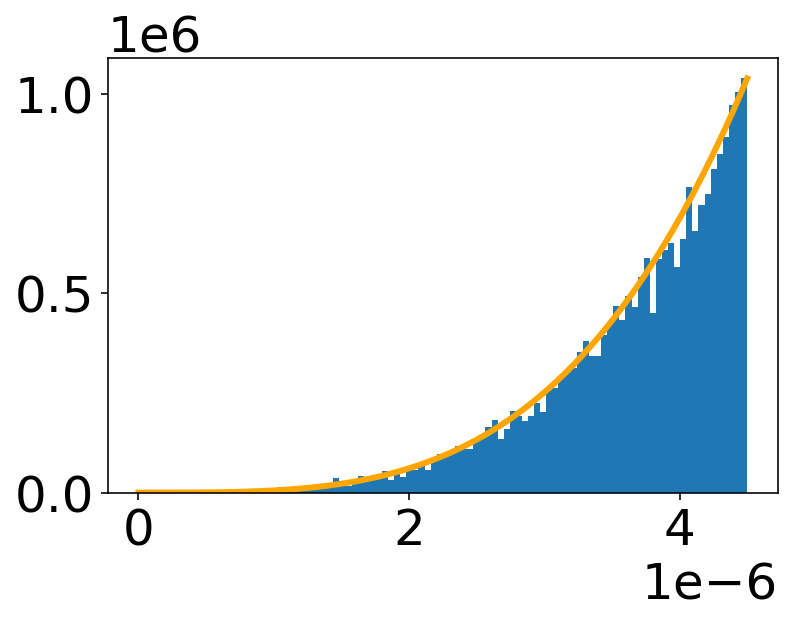

In [125]:
E_array = np.linspace(0, scp.psi(0), 1000)
hist = plt.hist(E_dis.value, bins=100, range=(0,scp.psi(0).value), density=True);
plt.plot(E_array, scp.df(E_array)/scp.df(E_array.max()) * hist[0].max(), c='orange', lw=3)



Transform the energy distribution to velocities using

$\mathcal{E} = \Psi -  \frac{1}{2}v^2$  
$v = \sqrt{2(\Psi - \mathcal{E})}$  

In [126]:
b = 1
ru = np.random.uniform(size=600000)
r_dis = b*1/np.sqrt(ru**(-2/3)-1)

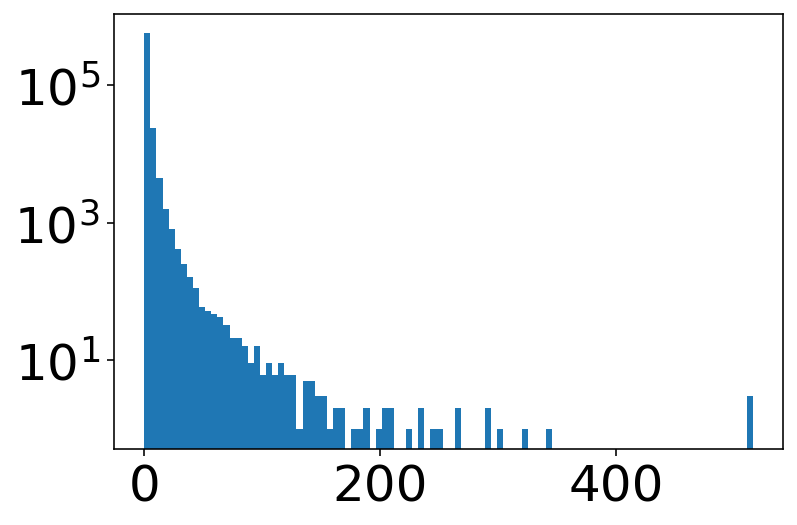

In [132]:
plt.hist(r_dis, bins=100, log=True);

In [ ]:
np.random.beta()

In [ ]:
np.random.power()

# 2.2: Test of equilibrium

Use the orbital integrator (see the code in [Section 2.1](#2.1:-Sampling-a-system-following-a-Plummer-profile)) to test if the system generated is in equilibrium (and self-consistent).   
That is:   
- Integrate the orbits in the Plummer potential associated to the density profile from [Section 2.1](#2.1:-Sampling-a-system-following-a-Plummer-profile), for $\sim 1$ Gyr and inspect the (spatial and kinematic) distribution of particles as a function of time.   
- How does the system behave? Why?
- Think what properties of the distribution you expect to evolve/remain constant. Is the outcome as you expected?

# 2.3:  A small galaxy embedded in a dark matter halo
For the final part we will generate a new stellar system: a spherical galaxy in a dark matter halo. For simplicity, assume that both components are described by a Plummer profile.   
For the stellar component use $M_\star = 10^4 {\rm M}_\odot$ and scale $b_\star= 0.05$ kpc and for the dark matter component use $M_{\rm DM} = 10^6 {\rm M}_\odot$ and scale $b_{\rm DM} = 1$ kpc.

Use the same method as before to generate the spatial distribution of the stellar component.

To obtain the velocities of the stars we will have to solve the Jeans equations.  
The Jeans equation in spherical coordinates are (Section 4.8.1 of Binney & Tremaine):  
$ \large \frac{d\big(\rho_\star(r)\sigma_v(r)\big)}{dr} + \rho_\star(r) \frac{d\Phi(r)}{dr}= 0$ 

Use the equation above to find the velocity dispersion of the system as a function of radius $\sigma_v(r)$.
Assume that the potential is dominated by the dark matter component. For the density in the equation above use the density of the stellar component.   
Finally, by assuming that the velocity distribution is well described by a Gaussian, generate velocities for the stellar particles using the velocity dispersion obtained from the Jeans equation.   


Repeat the steps of [Section 2.2](#2.2:-Test-of-equilibrium) and compare the results.



# Example: Integrating orbits in Gala

https://github.com/adrn/gala  
See the readthedocs page for instructions on how to use the code  
https://gala-astro.readthedocs.io/en/  
Also, check out the tutorials for some examples:  
https://gala-astro.readthedocs.io/en/latest/index.html#tutorials

In [3]:
# Some additional imports
import gala
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import gala.integrate as gi


In [4]:
# The benefit of using e.g. Gala is that the code keeps track of the units.
unit_dict = galactic.to_dict()
for key in unit_dict:
    print(f'Unit of {key:15} = {unit_dict[key]}')

Unit of length          = kpc
Unit of time            = Myr
Unit of mass            = solMass
Unit of angle           = rad
Unit of speed           = km / s


In the example below we will integrate an orbit in a Kepler potential 

In [5]:
potential = gp.IsochronePotential(m=1e11*u.Msun, b=2*u.kpc, units=gala.units.galactic)

Now we set the initial conditions for the orbit. They are stored in the array `w0`.

In [6]:
w0 = gd.PhaseSpacePosition(pos=[8, 0, 0]*u.kpc, # xyz
                           vel=[0, 200, 0]*u.km/u.s)  # v_xyz

# PhaseSpacePosition is not restricted to single orbits. 
# pos and vel can be arrays.

Gala offers two integrators. The default integrator is a `Leapfrog`, the other option is a `DOP853`, which is what we used in the previous lab.  
The benefit of the DOP853 is that is calculates the timestep adaptively. On the other hand, the `Leapfrog` algorithm conserves the energy on average (i.e. there is no drifting), and it is also typically faster.  
When using the `Leapfrog`, make sure that the time-step is sufficiently small, but not too small. Explain your choice of the timestep using concepts such as the crossing time of the system, or the orbital period.

In [7]:
Hamiltonian = gp.Hamiltonian(potential)

orbit = Hamiltonian.integrate_orbit(w0, dt=1.*u.Myr, n_steps=1000, Integrator=gi.LeapfrogIntegrator) # default

orbit2 = Hamiltonian.integrate_orbit(w0, t = np.linspace(0,1,1000)*u.Gyr, Integrator=gi.DOPRI853Integrator)

In [8]:
orbit.xyz

<Quantity [[ 8.        ,  7.99792152,  7.99168783, ...,  8.16173947,
             8.26316115,  8.36273223],
           [ 0.        ,  0.20454243,  0.4089786 , ..., -7.58110963,
            -7.47482706, -7.36687046],
           [ 0.        ,  0.        ,  0.        , ...,  0.        ,
             0.        ,  0.        ]] kpc>

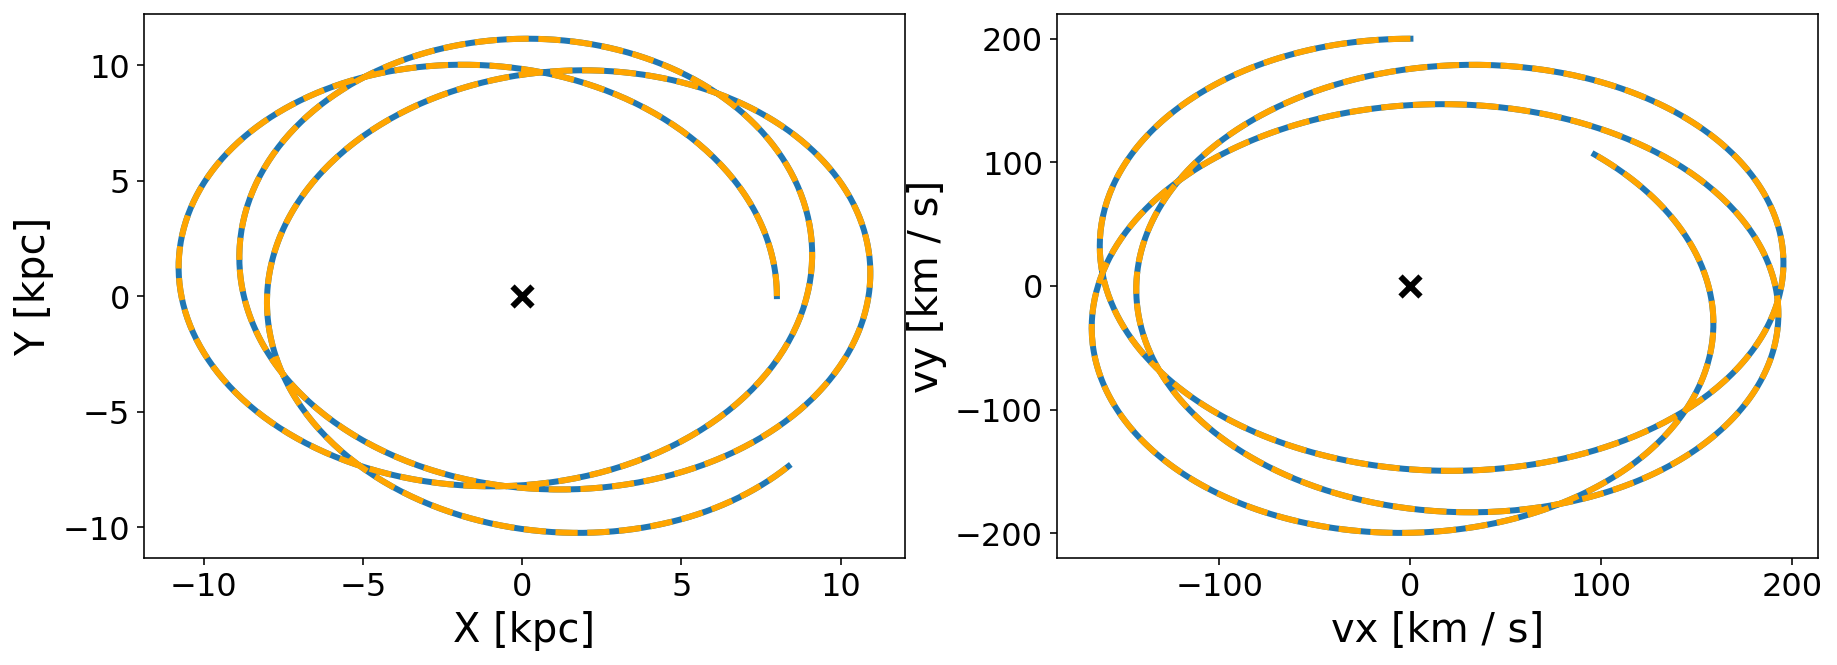

In [9]:
fig,axes = plt.subplots(ncols = 2, figsize=(15,5))


axes[0].plot(orbit.x, orbit.y,lw=3)
axes[0].plot(orbit2.x, orbit2.y, c='orange', ls='dashed',lw=3)
axes[0].scatter(0,0,marker='x',c='k')
axes[0].set_xlabel(f'X [{orbit.x.unit}]')
axes[0].set_ylabel(f'Y [{orbit.y.unit}]')


vx, vy, vz = orbit.v_xyz.to(u.km/u.s)
axes[1].plot(vx, vy,lw=3)
vx, vy, vz = orbit2.v_xyz.to(u.km/u.s)
axes[1].plot(vx, vy, c='orange', ls='dashed',lw=3)
axes[1].scatter(0,0,marker='x',c='k')
axes[1].set_xlabel(f'vx [{vx.unit}]')
axes[1].set_ylabel(f'vy [{vy.unit}]')


plt.show()

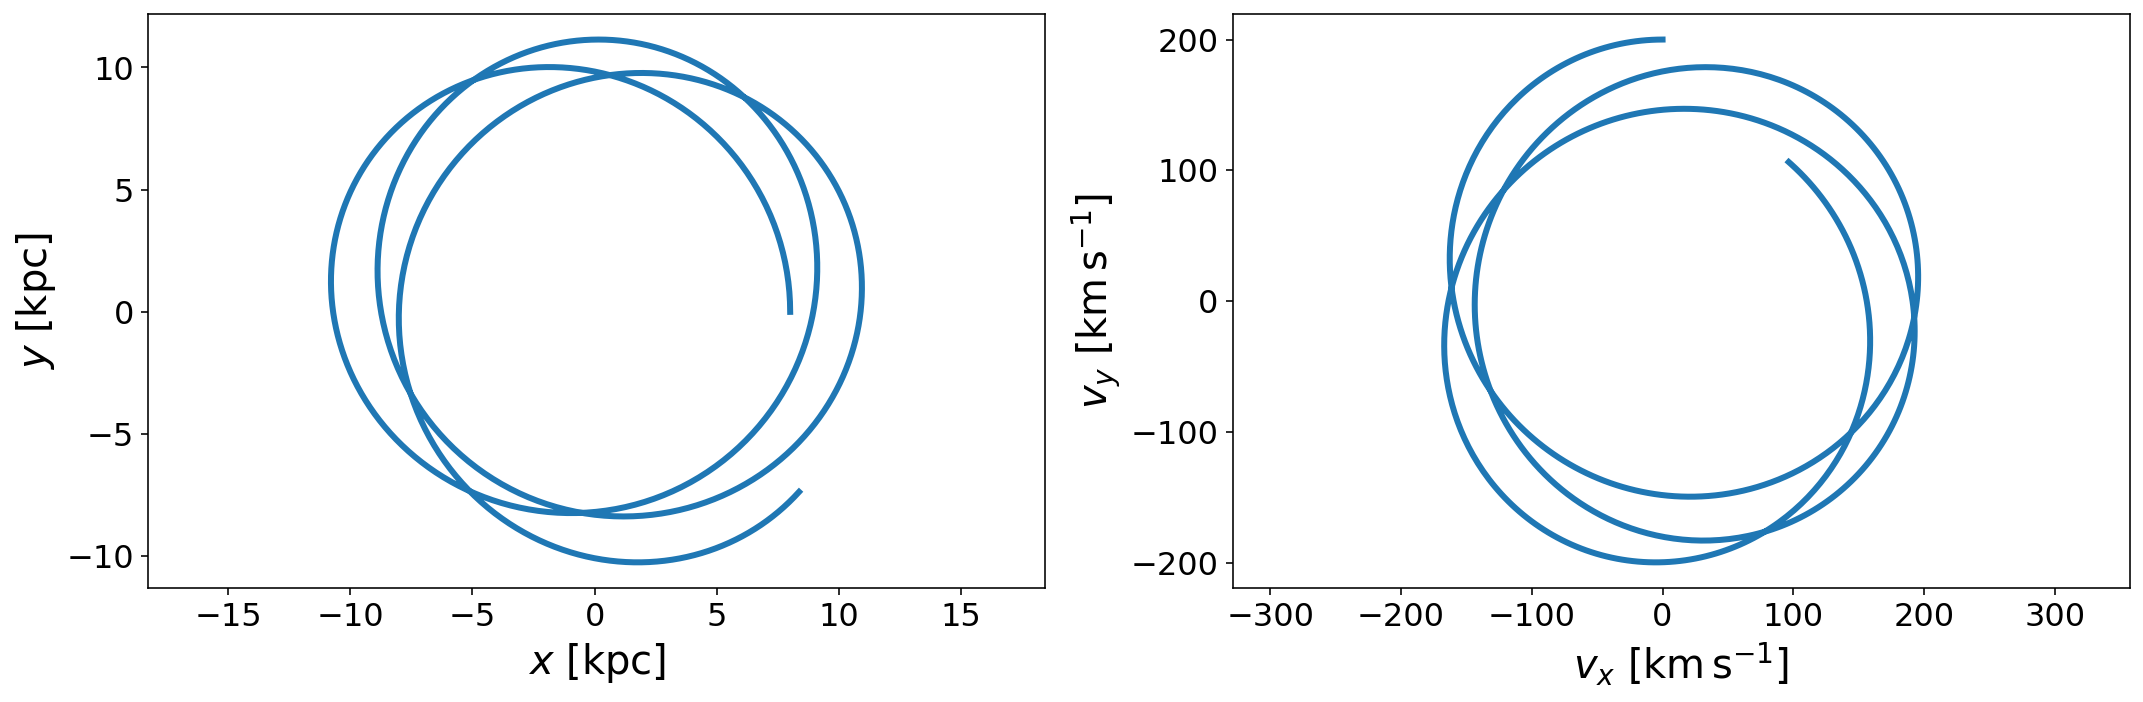

In [10]:
# Or simply:

fig,axes = plt.subplots(ncols = 2, figsize=(15,5))

orbit.plot(['x','y'], units=[u.kpc, u.kpc], axes=[axes[0]])

orbit.plot(['v_x','v_y'], units=[u.km/u.s,u.km/u.s], axes=[axes[1]])

plt.show()

### Conservation of energy and angular momentum for the two integrators.

In [11]:
(100000 * u.Myr).to('Gyr')

<Quantity 100. Gyr>

In [12]:
orbit = Hamiltonian.integrate_orbit(w0, dt=1.*u.Myr, n_steps=10000, Integrator=gi.LeapfrogIntegrator) # default

orbit2 = Hamiltonian.integrate_orbit(w0, t = np.linspace(0,10,1000)*u.Gyr, Integrator=gi.DOPRI853Integrator)

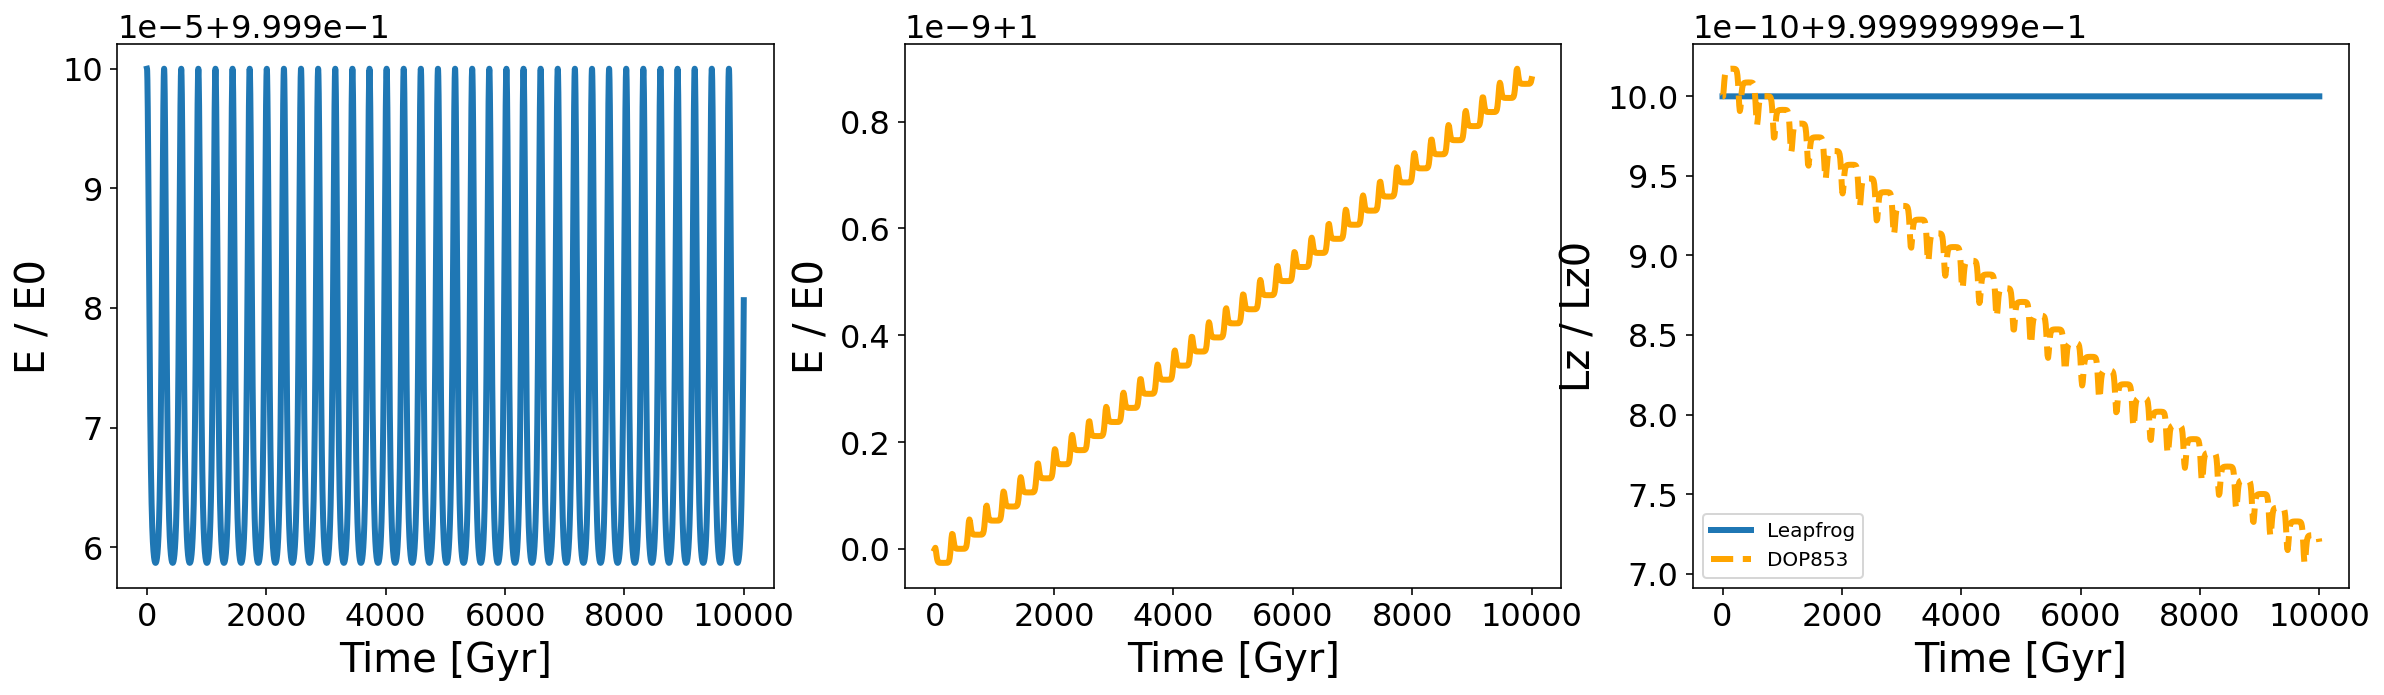

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))

E, L = orbit.energy(), orbit.angular_momentum()

Lz = L[2]
axes[0].plot(orbit.t, E/E[0])
axes[2].plot(orbit.t, Lz/Lz[0], label='Leapfrog')

E, L = orbit2.energy(), orbit2.angular_momentum()
Lz = L[2]
axes[1].plot(orbit2.t, E/E[0], c='orange')
axes[2].plot(orbit2.t, Lz/Lz[0], ls='--', c='orange', label='DOP853')


axes[0].set_ylabel('E / E0')
axes[1].set_ylabel('E / E0')
axes[2].set_ylabel('Lz / Lz0')

axes[0].set_xlabel('Time [Gyr]')
axes[1].set_xlabel('Time [Gyr]')
axes[2].set_xlabel('Time [Gyr]')

plt.legend()
plt.show()

The energy is conserved in a leapfrog integrator, but not in the DOP853 integrator.

### Orbit inspection in 3D

In [15]:
import ipyvolume as ipv

In [16]:
fig = ipv.figure(width=800, height=500)
ipv.plot(*orbit.xyz.value, color='black')

ipv.xyzlim(-15,15)
ipv.xlabel('x [kpc]')
ipv.ylabel('y [kpc]')
ipv.zlabel('z [kpc]')

ipv.show()

# Click, drag, and zoom-in to inspect the orbit

### Bonus:
To create an animation of the stream in 3D, follow last example of   
https://ipyvolume.readthedocs.io/en/latest/animation.html#Animated-quiver